In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [3]:
price = pd.read_csv("/content/dynamic_pricing.csv")
price.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
print(price.isnull().sum())
print(price.duplicated().sum())
print(price.shape)
print(price.info())
print(price.describe())
# print(np.isinf(price).sum())

Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64
0
(1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non

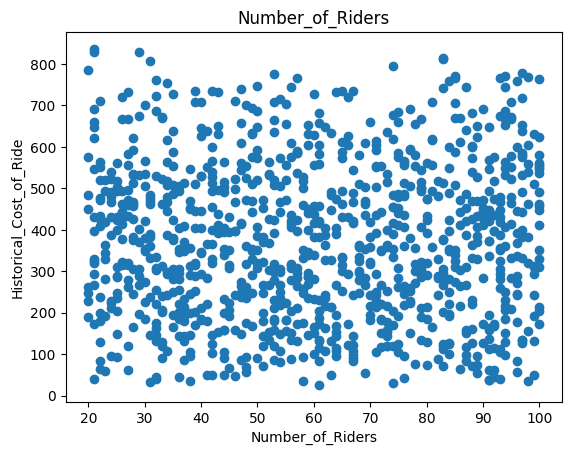

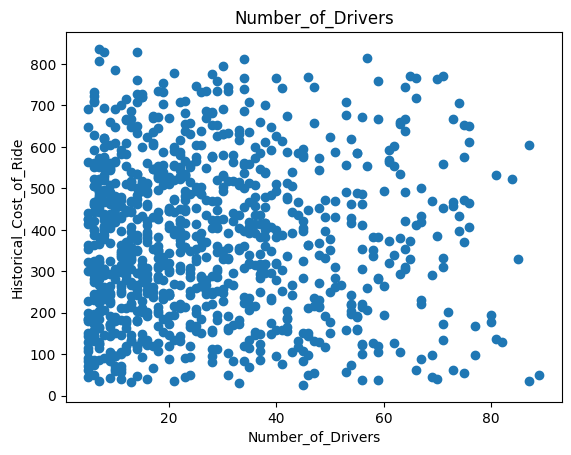

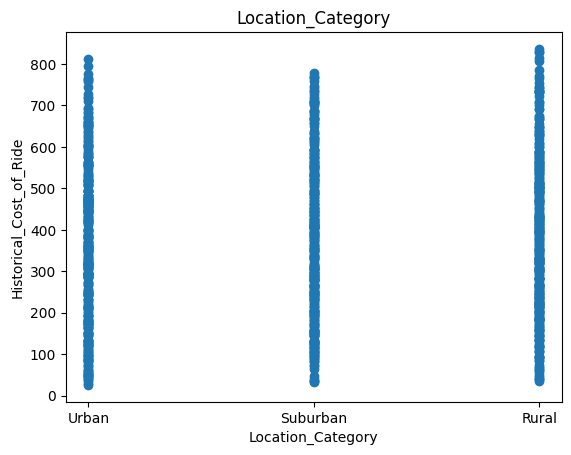

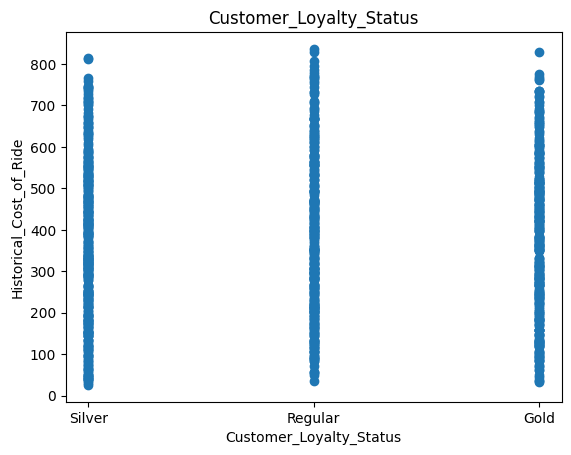

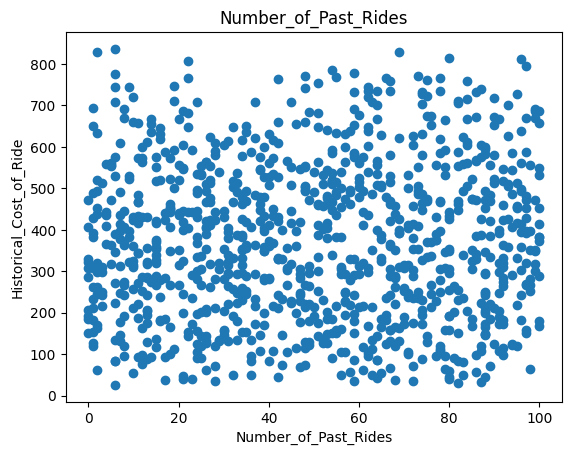

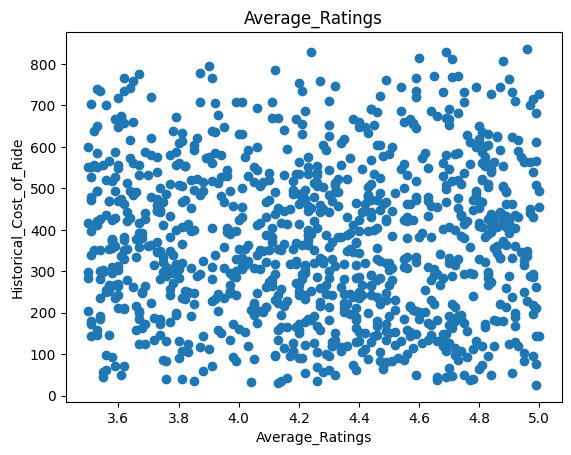

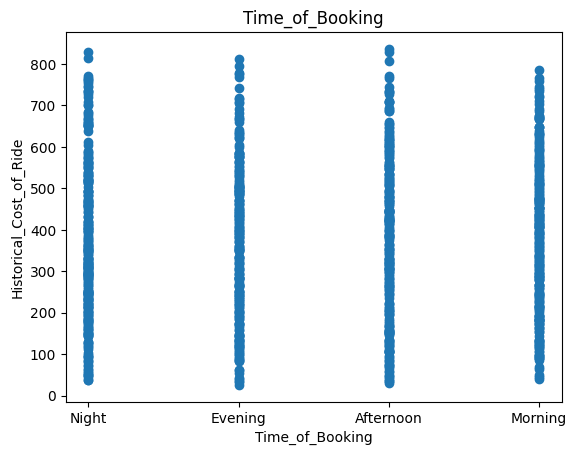

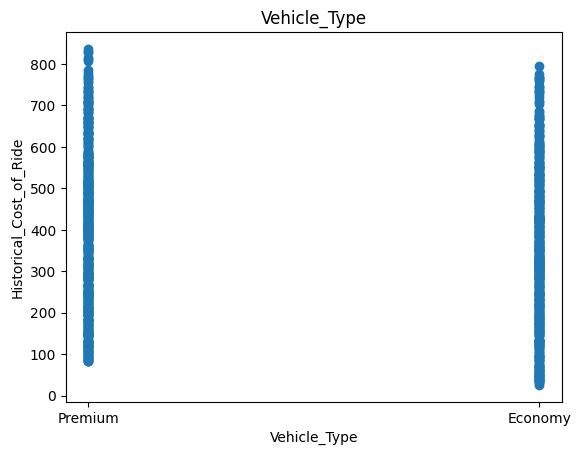

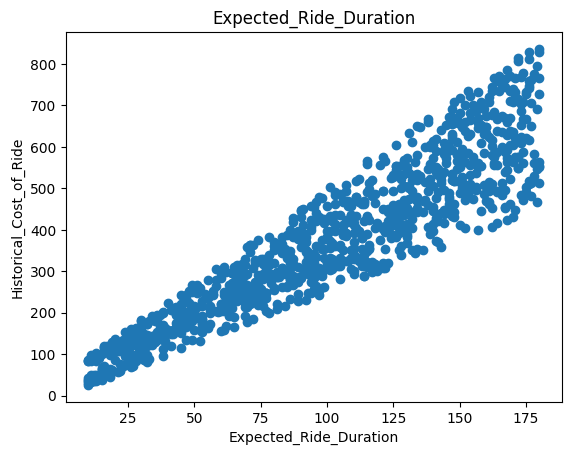

In [5]:
for label in price.columns[:-1]:
  plt.scatter(price[label], price["Historical_Cost_of_Ride"])
  plt.title(label)
  plt.ylabel("Historical_Cost_of_Ride")
  plt.xlabel(label)
  plt.show()

In [6]:
fig = px.scatter(price, x='Expected_Ride_Duration',
                 y='Historical_Cost_of_Ride',
                 title='Expected Ride Duration vs. Historical Cost of Ride',
                 trendline='ols')
fig.show()

# *preproccessing*

In [9]:
# this cell just for convert categorical to numeric(maping)
# from figure out the number of each Variable
# just for dataset
counts1 = price["Location_Category"].value_counts()
counts2 = price["Customer_Loyalty_Status"].value_counts()
counts3 = price["Time_of_Booking"].value_counts()
counts4 = price["Vehicle_Type"].value_counts()
print(counts1)
print(counts2)
print(counts3)
print(counts4)

Location_Category
Urban       346
Rural       332
Suburban    322
Name: count, dtype: int64
Customer_Loyalty_Status
Silver     367
Regular    320
Gold       313
Name: count, dtype: int64
Time_of_Booking
Night        276
Afternoon    247
Morning      246
Evening      231
Name: count, dtype: int64
Vehicle_Type
Premium    522
Economy    478
Name: count, dtype: int64


In [10]:
# this function for converting astegorical to numeric (map method)
def numeric (num):
  num["Vehicle_Type"] = (num["Vehicle_Type"] == "Premium").astype(int)
  num["Location_Category"] = num["Location_Category"].map({"Urban":3,"Rural":2,"Suburban":1})
  num["Time_of_Booking"] = num["Time_of_Booking"].map({"Night":4,"Afternoon":3,"Morning":2,"Evening":1})
  num["Customer_Loyalty_Status"] = num["Customer_Loyalty_Status"].map({"Silver":3,"Regular":2,"Gold":1})

  return num

In [11]:
numeric(price)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,3,3,13,4.47,4,1,90,284.257273
1,58,39,1,3,72,4.06,1,0,43,173.874753
2,42,31,2,3,0,3.99,3,1,76,329.795469
3,89,28,2,2,67,4.31,3,1,134,470.201232
4,78,22,2,2,74,3.77,3,0,149,579.681422
...,...,...,...,...,...,...,...,...,...,...
995,33,23,3,1,24,4.21,2,1,11,91.389526
996,84,29,3,2,92,4.55,2,1,94,424.155987
997,44,6,1,1,80,4.13,4,1,40,157.364830
998,53,27,1,2,78,3.63,4,1,58,279.095048


In [12]:
# take corrulation that figure out the efects of each column on levelstress
corr = price.corr()
corr["Historical_Cost_of_Ride"].sort_values(ascending=False)

,Historical_Cost_of_Ride
Historical_Cost_of_Ride,1.000000
Expected_Ride_Duration,0.927547
Vehicle_Type,0.132640
Number_of_Past_Rides,0.035859
Number_of_Drivers,0.017082
Number_of_Riders,0.005826
Time_of_Booking,0.004416
Average_Ratings,-0.001063
Location_Category,-0.023818
Customer_Loyalty_Status,-0.030553


In [13]:
corr_matrix = price.corr()

fig = go.Figure(data=go.Heatmap(z=corr_matrix.values,
                                x=corr_matrix.columns,
                                y=corr_matrix.columns,
                                colorscale='Viridis'))
fig.update_layout(title='Correlation Matrix')
fig.show()

In [14]:
price["Number_of_Riders/Number_of_Drivers"] = price["Number_of_Riders"]/price["Number_of_Drivers"]
price["Number_of_Drivers/Number_of_Riders"] = price["Number_of_Drivers"]/price["Number_of_Riders"]

In [15]:
# this function for remove useless columns
def drop (dr):
  dr.drop(columns=["Number_of_Riders","Time_of_Booking","Average_Ratings"], inplace=True)

  return dr

In [16]:
drop(price)

,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Number_of_Riders/Number_of_Drivers,Number_of_Drivers/Number_of_Riders
0,45,3,3,13,1,90,284.257273,2.000000,0.500000
1,39,1,3,72,0,43,173.874753,1.487179,0.672414
2,31,2,3,0,1,76,329.795469,1.354839,0.738095
3,28,2,2,67,1,134,470.201232,3.178571,0.314607
4,22,2,2,74,0,149,579.681422,3.545455,0.282051
...,...,...,...,...,...,...,...,...,...
995,23,3,1,24,1,11,91.389526,1.434783,0.696970
996,29,3,2,92,1,94,424.155987,2.896552,0.345238
997,6,1,1,80,1,40,157.364830,7.333333,0.136364
998,27,1,2,78,1,58,279.095048,1.962963,0.509434


## *solve outlayers and noises (IQR)*

In [17]:
def data_preprocessing_pipeline(data):
    #Identify numeric and categorical features
    numeric_features = data.select_dtypes(include=['float', 'int']).columns
    # categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    # data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    #Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature])

    #Handle missing values in categorical features
    # data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data

In [18]:
data_preprocessing_pipeline(price)

,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,Number_of_Riders/Number_of_Drivers,Number_of_Drivers/Number_of_Riders
0,45.0,3.0,3.0,13.0,1.0,90.0,284.257273,2.000000,0.500000
1,39.0,1.0,3.0,72.0,0.0,43.0,173.874753,1.487179,0.672414
2,31.0,2.0,3.0,0.0,1.0,76.0,329.795469,1.354839,0.738095
3,28.0,2.0,2.0,67.0,1.0,134.0,470.201232,3.178571,0.314607
4,22.0,2.0,2.0,74.0,0.0,149.0,579.681422,3.545455,0.282051
...,...,...,...,...,...,...,...,...,...
995,23.0,3.0,1.0,24.0,1.0,11.0,91.389526,1.434783,0.696970
996,29.0,3.0,2.0,92.0,1.0,94.0,424.155987,2.896552,0.345238
997,6.0,1.0,1.0,80.0,1.0,40.0,157.364830,3.235461,0.136364
998,27.0,1.0,2.0,78.0,1.0,58.0,279.095048,1.962963,0.509434


## *Train/Test/Validation*

In [19]:
train, val, test = np.split(price.sample(frac=1), [int(0.6*len(price)), int(0.8*len(price))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [20]:
def scale_dataset(scale):
  x = scale.drop('Historical_Cost_of_Ride', axis=1)
  y =scale['Historical_Cost_of_Ride']

  return x, y

In [21]:
x_train, y_train = scale_dataset(train)
x_test, y_test = scale_dataset(test)
x_val, y_val = scale_dataset(val)

# ***Models***

### *LinearRegression*

In [22]:
# LinearRegression
all_reg = LinearRegression()
all_reg.fit(x_train, y_train)

LinearRegression()

In [23]:
all_reg.score(x_test, y_test)

0.8756734587652644

### *RandomForestRegressor*

In [24]:
forest = RandomForestRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=2, n_estimators=200, random_state=42).fit(x_train, y_train)

In [25]:
y_pred = forest.predict(x_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 5416.48


In [26]:
forest.score(x_test, y_test)

0.8557166806837846

In [27]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and the corresponding score
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_:.2f}')

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: -4900.24


### *DecisionTreeRegressor*

In [32]:
tree = DecisionTreeRegressor(random_state=42)
tree.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = tree.predict(x_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 11319.53


In [33]:
tree.score(x_test,y_test)

0.6984719511441873

### *SVR*

In [34]:
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = svr.predict(x_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 35394.44


In [35]:
svr.score(x_test,y_test)

0.05716809454588723

### *GradientBoostingRegressor*

In [36]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
gbr.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = gbr.predict(x_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 5153.60


In [37]:
gbr.score(x_test,y_test)

0.862719090919545

# ***Neural Net***

In [38]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [107]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(8,), axis=-1)
all_normalizer.adapt(x_train)

nn_model = tf.keras.Sequential([
    all_normalizer,
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



history = nn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val_all),
    verbose=0, epochs=100
)

In [108]:
history = nn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 172504.7500 - val_loss: 169991.0469
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 167320.0469 - val_loss: 168859.5000
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 178961.3125 - val_loss: 167141.1250
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 164392.5000 - val_loss: 164611.4375
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 170256.8594 - val_loss: 160874.6719
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 161443.2656 - val_loss: 155661.3594
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 150235.3594 - val_loss: 148541.6875
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 147002.3906 - val_loss: 139328.0625
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 126051.9922 - val_loss: 128126.0938
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 123272.4297 - val_loss: 114721.5391
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

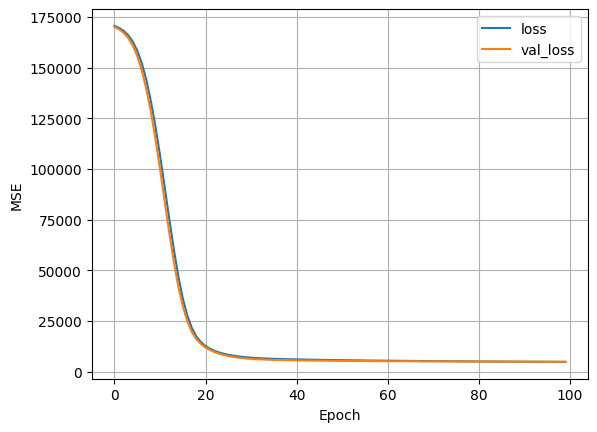

In [109]:
plot_loss(history)

In [46]:
# calculate the MSE for both linear reg and nn
y_pred_lr = all_reg.predict(x_test)
y_pred_nn = nn_model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [50]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [51]:
MSE(y_pred_lr, y_test)

4667.288531348993

In [110]:
mse = nn_model.evaluate(x_test, y_test)
print(f'MSE: {mse:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5137.1865 
MSE: 5433.39


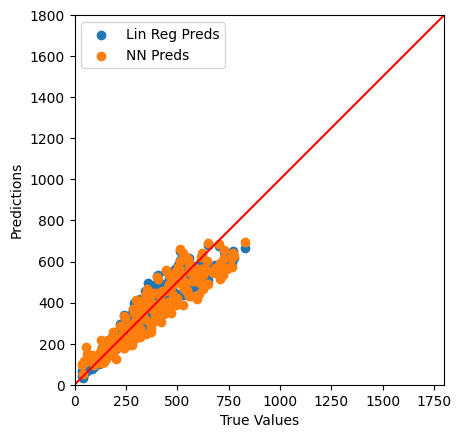

In [111]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")